# Notes & Practice: Apache Spark for PCA

## Dimensionality reduction
- takes an n-dimensional, euclidian vector space R^n
- span a new k-dimensional, euclidien vector space R^k 
- the new k-dimensiona 'explain' most of the variation: the principle components

the logis is: if two points are far away in the original dataset, they will be far away in the new k-dimensional dataset

PCA removes information of dimensions which have a high correlation with each other because information content of highly correlated dimension is lower as with weakly correlated ones.
- PCA removes the most irrelevant dimensions by creating a lower dimensional data set with newly created columns but preserving distance properties between individual rows

- when applying PCA: we lose information, but keep key information
- the lower the k, the higher the loss is
- loss is measured by reconstruction error
loss = sse(D, PCA^-1(PCA(D)))
sum of squared erroes: sse(x, y) = 1/n * sqrt(sum(xi - yi)**2)



- use the 'washing.parquet' data to showcase PCA

In [22]:
try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
except ImportError as e:
    printmd('<! Please restart your kernel after installing Apache Spark !>')

In [23]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession.builder.getOrCreate()

In [24]:
# get data
!wget https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
!mv washing.parquet?raw=true washing.parquet

--2020-05-11 05:42:45--  https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true [following]
--2020-05-11 05:42:45--  https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet [following]
--2020-05-11 05:42:45--  https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/skillsnetwork/master/coursera_ds/washing.parquet [fo

In [25]:
# create a dataframe
df = spark.read.parquet('washing.parquet')
df.createOrReplaceTempView('washing')
df.show()

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0d86485d0f88d1f9d...|1-57940679fb8a713...|    4|      11|acceptable|     null|      77| null|        100|1547808723923|   null|
|0d86485d0f88d1f9d...|1-15ff3a0b304d789...|    2|    null|      null|     null|    null| 1046|       null|1547808729917|   null|
|0d86485d0f88d1f9d...|1-97c2742b68c7b07...|    4|    null|      null|       71|    null| null|       null|1547808731918|    236|
|0d86485d0f88d1f9d...|1-eefb903dbe45746...|   19|      11|acceptable|     null|      75| null|         86|1547808738999|   null|
|0d86485d0f88d1f9d...|1-5f68b4c72813c25...|    7|    null|      null|       75|    null| null|   

In [26]:
# or use Spark SQL
df.createOrReplaceTempView("washing")
spark.sql("SELECT * FROM washing").show()

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0d86485d0f88d1f9d...|1-57940679fb8a713...|    4|      11|acceptable|     null|      77| null|        100|1547808723923|   null|
|0d86485d0f88d1f9d...|1-15ff3a0b304d789...|    2|    null|      null|     null|    null| 1046|       null|1547808729917|   null|
|0d86485d0f88d1f9d...|1-97c2742b68c7b07...|    4|    null|      null|       71|    null| null|       null|1547808731918|    236|
|0d86485d0f88d1f9d...|1-eefb903dbe45746...|   19|      11|acceptable|     null|      75| null|         86|1547808738999|   null|
|0d86485d0f88d1f9d...|1-5f68b4c72813c25...|    7|    null|      null|       75|    null| null|   

In [28]:
# select results and create variables: temperature, voltage, flowrate, frequency, hardness, speed

# create 12 new features from 6 existing features
result = spark.sql("""
SELECT * 
from (
    SELECT
    min(temperature) over w as min_temperature,
    max(temperature) over w as max_temperature, 
    min(voltage) over w as min_voltage,
    max(voltage) over w as max_voltage,
    min(flowrate) over w as min_flowrate,
    max(flowrate) over w as max_flowrate,
    min(frequency) over w as min_frequency,
    max(frequency) over w as max_frequency,
    min(hardness) over w as min_hardness,
    max(hardness) over w as max_hardness,
    min(speed) over w as min_speed,
    max(speed) over w as max_speed
    FROM washing 
    WINDOW w AS (ORDER BY ts ROWS BETWEEN CURRENT ROW AND 10 FOLLOWING)   -- group 11 subsequent rows together as a window w
)
WHERE min_temperature is not null 
AND max_temperature is not null
AND min_voltage is not null
AND max_voltage is not null
AND min_flowrate is not null
AND max_flowrate is not null
AND min_frequency is not null
AND max_frequency is not null
AND min_hardness is not null
AND min_speed is not null
AND max_speed is not null   
""")

# sliding window

In [30]:
type(result)

pyspark.sql.dataframe.DataFrame

In [29]:
result.count()

2051

In [21]:
# check null values
df.count() - result.count()

7

In [11]:
# import modules
from pyspark.ml.feature import PCA
# array does not work; need to convert arrays into a Spark machine learning vector object
from pyspark.ml.linalg import Vectors 
# VectorAssembler: transform data into these vector structures.
from pyspark.ml.feature import VectorAssembler 

In [34]:
# convert data into vectors
assembler = VectorAssembler(inputCols=result.columns, outputCol="features")
features = assembler.transform(result) # transform data
print(type(features))
print(features.show())

<class 'pyspark.sql.dataframe.DataFrame'>
+---------------+---------------+-----------+-----------+------------+------------+-------------+-------------+------------+------------+---------+---------+--------------------+
|min_temperature|max_temperature|min_voltage|max_voltage|min_flowrate|max_flowrate|min_frequency|max_frequency|min_hardness|max_hardness|min_speed|max_speed|            features|
+---------------+---------------+-----------+-----------+------------+------------+-------------+-------------+------------+------------+---------+---------+--------------------+
|             81|            100|        221|        223|          11|          11|           68|           76|          71|          78|     1033|     1033|[81.0,100.0,221.0...|
|             81|            100|        221|        223|          11|          11|           68|           76|          72|          78|     1033|     1033|[81.0,100.0,221.0...|
|             81|            100|        221|        223|      

In [32]:
features.rdd.map(lambda r : r.features).take(10) 
 # matrix format

[DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 11.0, 68.0, 76.0, 71.0, 78.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 11.0, 68.0, 76.0, 72.0, 78.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 11.0, 68.0, 76.0, 72.0, 80.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 222.0, 223.0, 11.0, 11.0, 68.0, 74.0, 72.0, 80.0, 1033.0, 1046.0]),
 DenseVector([81.0, 100.0, 222.0, 223.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1033.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 223.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1033.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1046.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1046.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 71.0, 74.0, 73.0, 80.0, 1046.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 71.0, 74.0, 73.0, 80.0, 1046.0, 1046.0])]

In [36]:
# define number of resulting features
pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(features)

In [37]:
# pass the data into model
result_pca = model.transform(features).select("pcaFeatures")
result_pca.show(truncate=False)

# result: 3 values, not 12 in each row

+-----------------------------------------------------------+
|pcaFeatures                                                |
+-----------------------------------------------------------+
|[1459.9789705814187,-18.745237781780922,70.78430794796873] |
|[1459.995481828676,-19.11343146165273,70.72738871425986]   |
|[1460.0895843561282,-20.969471062922928,70.75630600322052] |
|[1469.6993929419532,-20.403124647615513,62.013569674880955]|
|[1469.7159041892107,-20.771318327487293,61.95665044117209] |
|[1469.7128317338704,-20.790751117222456,61.896106678330966]|
|[1478.3530264572928,-20.294557029728722,71.67550104809607] |
|[1478.3530264572928,-20.294557029728722,71.67550104809607] |
|[1478.3686036138165,-20.260626897636314,71.63355353606426] |
|[1478.3686036138165,-20.260626897636314,71.63355353606426] |
|[1483.5412027684088,-20.006222577501354,66.82710394284209] |
|[1483.5171090223353,-20.867020421583753,66.86707301954084] |
|[1483.4224268542928,-19.87574823665505,66.93027077913985]  |
|[1483.4

In [38]:
# check if the number of rows are same
result_pca.count()

2051

In [43]:
# sample data
rdd = result_pca.rdd.sample(False,0.8)
# seperate 3 features; extract each feature
x = rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[0]).collect()
y = rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[1]).collect()
z = rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[2]).collect()


# x, y, z here are lists

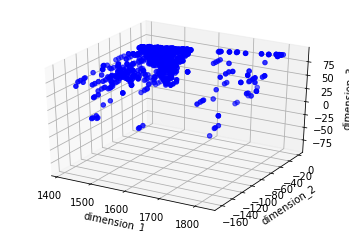

In [46]:
# build a 3 dimensional model 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(x,y,z, c='b', marker='o')

ax.set_xlabel('dimension_1')
ax.set_ylabel('dimension_2')
ax.set_zlabel('dimension_3')

plt.show()